<a href="https://colab.research.google.com/github/ffer200395/Arthropod-proteins-classification/blob/main/Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Bio
!pip install keras-tuner --upgrade
!pip install tensorflow-addons

In [ ]:
import os
import numpy as np
from numpy import random
import pandas as pd
from tqdm import tqdm
from google.colab import drive

import pickle
import json
import shlex
import subprocess
from bs4 import BeautifulSoup

from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import pickle

import keras
import keras_tuner as kt
import keras.backend as K
from tensorflow_addons.metrics import F1Score as f1
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, BatchNormalization, LSTM, SimpleRNN
from keras.metrics import *
from keras.utils.vis_utils import plot_model

from sklearn.metrics import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from numpy.random import seed, rand, randint
from numpy import mean, median, percentile

In [ ]:
# Path
path = '/content/gdrive/MyDrive/TFM/arthropod proteins classification/data/'
# Mount drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Step 0: Scan sequences

## Once amino acid sequences have been downloaded from UniProt:

- Sequences are scanned using the tool hmmscan from EMBL-EBI API so raw results from all sequences about its domain is obtained.

- Raw results are stored in order to apply a filtering criteria later.

In [ ]:
def create_temp(id, seq, temp_file):
  """Create a temp file for a sequence before APi call is done

  Parameters
  ----------
  id : str
      ID of the sequence to be scanned
  seq : str
      Sequence to be scanned
  Returns
  -------
  None
      It creates a file called temp.seq
  """
  f = open(temp_file, "w")
  f.write(f">{id}\n{seq}")
  f.close()

def call_curl(curl):
    """Makes the API call for a sequence stored in a temp file

    Parameters
    ----------
    curl : str
        Command used to make API call
    Returns
    -------
    str
        Raw output as a string from HMMER API
    """
    args = shlex.split(curl)
    process = subprocess.Popen(args, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, _ = process.communicate()
    return stdout

def scan_seqs(seq_path, temp_file, curl):
  """Scans and all sequences contained in FASTA files

  Parameters
  ----------
  seq_path : str
      Location of FASTA files
  temp_file : str
      Location for temp file to be created
  curl : str
      Command used to make API call
  Returns
  -------
  DataFrame
      Columns: Sequence ID, Sequence, Category of the sequence, Output from API
  """
  files = os.listdir(seq_path)
  l_id, l_seq, l_cat, l_out, l_len = [], [], [], [], []
  # Every FASTA file is parsed
  for file in files:
    inFile = open(seq_path+file,'r')
    records = SeqIO.parse(inFile,'fasta')
    n_records = 0
    # For each record a temp file is created and then scanned
    for record in tqdm(records):
      n_records+=1
      create_temp(record.id, record.seq, temp_file)
      output = call_curl(curl)
      # Store data
      l_id.append(record.id)
      l_seq.append(str(record.seq))
      l_out.append(output)
      l_len.append(len(record.seq))
    l_cat+=[file.split('.')[0]]*n_records
  # DataFrame to be returned
  df_res = pd.DataFrame(list(zip(l_id,l_seq,l_cat,l_out,l_len)),columns = ['ID','Seq','Category','Output','Length'])
  return df_res

In [ ]:
# Scan all sequences
temp_file = path+'temp.seq'
curl = f"curl -L -H 'Expect:' -H 'Accept:text/xml' -F hmmdb=pfam -F seq='<{temp_file}' https://www.ebi.ac.uk/Tools/hmmer/search/hmmscan"
df_scanned = scan_seqs(path+'sequences/', temp_file, curl)
df_scanned.to_csv(path+'df_scanned.csv')

# Step 1: Apply filter
## Process API raw results to apply a filter:
- All hits must belong to the specified pfam
- All hits belonging evalue must have a evalue less or equal than a specified threshold
- Calculated domain must be higher or equal to a specified percentage


In [ ]:
def get_domain_pct(ls_domains, length):
  """Calculates the percentage of domain present in the sequence
  Parameters
  ----------
  ls_domains : list 
      List of locations where domain has been detected in the sequence
  length : int
      Length of the domain associated to pfam
  Returns
  -------
  float
      Percentage of domain present in the sequence
  """
  # Initially we assume no presence of the domain
  idxs = np.zeros((length,), dtype=int)
  for dom in ls_domains:
    # For every domain start and end indexes are obtained
    start, end = int(dom['alihmmfrom']), int(dom['alihmmto'])
    # We set to one all indexes within start and end idxs
    idxs[start-1:end]=1
  # Sum all indexes where domain has been present (thus overlapped segment are counted once), divide it over domain length
  return sum(idxs)/length

def seq_filter(output, pfam, length, eval):
  """Applies the filter criterium
  Parameters
  ----------
  output : str 
      sequence API output
  pfam : str
      Protein family (code) associated to sequences' category
  length : int
      Length of the domain associated to pfam
  eval : float
      Minimum evalue required
  Returns
  -------
  float
      Percentage of domain present in the sequence
  """
  soup = BeautifulSoup(str(output.splitlines()), "html.parser")
  ls_hits = soup.findAll("hits")
  # First all hits must belong to the same protein family (pfam)
  ls_hits_pfam = [hit for hit in ls_hits if hit['acc'].split('.')[0].lower()==pfam]
  # Second all hits of pfam which evalue is less or equal than eval
  ls_hits_evalue = [hit for hit in ls_hits_pfam if float(hit['evalue'])<=eval]
  # If after filtering by evalue there is nothing left or we found hits belonging to different pfams sequence is discarded
  if len(ls_hits_evalue)==0 or len(ls_hits)!=len(ls_hits_pfam):
    return 0.0
  # Third percentage of present domain is calculated
  else:
    domains = ls_hits_evalue[0].findAll("domains")
    dom_pct = get_domain_pct(domains, length)
    return dom_pct

def apply_filter(df, pfam_info, eval=1.e-6):
  """Applies the filter to all sequences
  Parameters
  ----------
  df : DataFrame 
      DataFrame with sequences and outputs from API
  pfam_info : dict
      Dictionary containing pfam code and domain length of each category 
  eval : float
      Minimum evalue required
  Returns
  -------
  DataFrame with an extra column for percentage of domain
  """
  l_dom = []
  categories, outputs = df['Category'], df['Output']
  for i,out in tqdm(enumerate(outputs)):
    # pfam code a length are obtained for each category
    pfam, length = pfam_info[categories[i].split('_')[0].lower()]
    # filter is applied and result is stored
    dom_pct = seq_filter(out, pfam, length, eval)
    l_dom.append(dom_pct)
  df['Domain_pct'] = l_dom
  return df

In [ ]:
# Read results from scanned sequences
df_scanned = pd.read_csv(path+'df_scanned.csv',index_col=0)

# Filter all sequences and store them
pfam_info = {'gr':('pf08395',371), 'or':('pf02949',313)} # Domain info for OR and GR
e_val = 1.e-6
domain_pct = 0.6 # At least 60% of the domain

df_filt = apply_filter(df_scanned, pfam_info, eval=e_val)
df_filt = df_filt[df_filt.Domain_pct>=domain_pct]
df_filt.to_csv(path+'df_filtered.csv')

19474it [00:15, 1220.19it/s]


# Step 2: Encode sequences

  ## As a previous step a standard length needs to be determined:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Length')

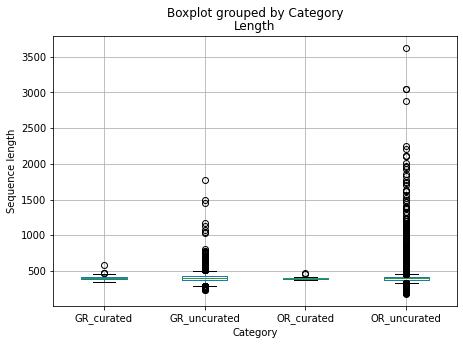

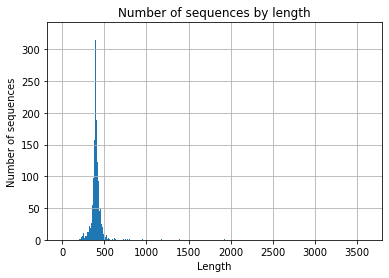

In [ ]:
# In order to analise sequences length by category and globally
df_filt = pd.read_csv(path+'df_filtered.csv',index_col=0)

df_filt.boxplot(column='Length',by='Category',figsize=(7,5))
plt.ylabel('Sequence length')
df_filt.hist('Length',bins=range(0,max(df_filt['Length'])+1,1))
plt.title('Number of sequences by length')
plt.ylabel('Number of sequences')
plt.xlabel('Length')

In [ ]:
mask = df_filt.Length<=600
# Percentage of sequences with lenght less or equal than 600
print(len(df_filt[mask])/len(df_filt)*100)

98.226122088252


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Length')

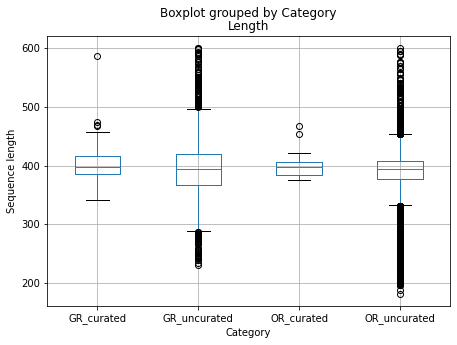

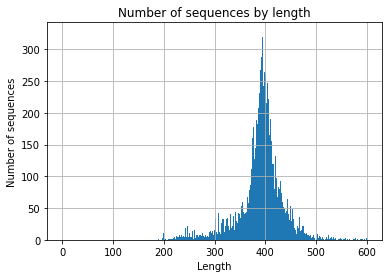

In [ ]:
# Boxplot and histogram with 600 threshold
df_filt[mask].boxplot(column='Length',by='Category',figsize=(7,5))
plt.ylabel('Sequence length')

df_filt[mask].hist('Length',bins=range(0,max(df_filt[mask]['Length'])+1,1))
plt.title('Number of sequences by length')
plt.ylabel('Number of sequences')
plt.xlabel('Length')

  ## After maximun length is selected we can start with encoding and padding

In [ ]:
def get_df_encoded(df, max_len, codes):
  """Generates a dataframe of encoded sequences
  Parameters
  ----------
  df : DataFrame 
      DataFrame with sequences to be enconded
  max_len : int 
      Max length of the sequence
  codes : dict
      Dictionary where each key is an amino acid and each value is its corresponding vector
  Returns
  -------
  pandas Dataframe
      Columns:Seq_ID, Seq, Category
  """
  ids, seqs, cats = df['ID'].values,df['Seq'],df['Category'].values
  n_features, ls_ids, ls_enc, ls_cat = len(list(codes.values())[0]), [], [], []
  for i,seq in tqdm(enumerate(seqs)):
    seq_aux = list(seq)
    # Only naturally occurring AA are considered
    if set(seq_aux).issubset(codes.keys()):
      # Encoding
      seq_enc = np.array([codes[aa] for aa in seq_aux],dtype=float).flatten()
      # Zero post-padding
      n_zero = (max_len*n_features)-len(seq_enc)
      seq_pad = np.pad(seq_enc, (0,n_zero), constant_values=0)
      # Store data
      ls_ids.append(ids[i])
      ls_cat.append(cats[i])
      ls_enc.append(list(seq_pad))
  cols=[f'F_{i}' for i in range(max_len*n_features)]
  res = pd.DataFrame(data=np.array(ls_enc),columns=cols)
  res['Seq_ID'] = ls_ids
  res['Category'] = ls_cat
  res.set_index('Seq_ID', inplace=True)
  return res

In [ ]:
# Sequences to be encoded
max_len = 600
df_to_encode = df_filt[df_filt.Length<=max_len]

# Load dictionaries of encondings
with open(path+'encodings.json') as json_file:
  d_codes = json.load(json_file)

for enc in ['10-factor', 'phy-chem', '1-hot']:
    df_encoded = get_df_encoded(df_to_encode, max_len, d_codes[enc])
    df_encoded.to_csv(path+f'df_encoded_{enc}.csv')

15560it [00:17, 901.84it/s]
15560it [00:11, 1332.25it/s]
15560it [00:26, 579.51it/s]


In [ ]:
print(f'From {len(df_filt)} to {len(df_encoded)} sequences')

# Percentage of samples per category
print(df_encoded['Category'].value_counts(normalize=True) * 100)

From 15841 to 15222 sequences
OR_uncurated    70.352122
GR_uncurated    28.984365
OR_curated       0.341611
GR_curated       0.321903
Name: Category, dtype: float64


# Step 3: Split the dataset into train, validation, test sets

- 60% for training dataset, 20% for validation, 20% for testing

In [ ]:
def get_datasets(filename):
  df_encoded = pd.read_csv(filename, index_col='Seq_ID')

  # Separate curated and uncurated sequences
  df_curated = df_encoded[(df_encoded.Category=='GR_curated')|(df_encoded.Category=='OR_curated')].copy()
  df_uncurated = df_encoded[(df_encoded.Category=='GR_uncurated')|(df_encoded.Category=='OR_uncurated')].copy()

  # Convert category into binary
  df_curated["Category"].replace({"GR_uncurated":0,"GR_curated":0,"OR_uncurated":1,"OR_curated":1}, inplace=True)
  df_uncurated["Category"].replace({"GR_uncurated":0,"GR_curated":0,"OR_uncurated":1,"OR_curated":1}, inplace=True)

  # Get X matrix and y vector
  X, X_c = np.array(df_uncurated.iloc[:,:-1]), np.array(df_curated.iloc[:,:-1])
  y, y_c = df_uncurated['Category'].values, df_curated['Category'].values

  # Rule of 60-20-20
  X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.4, random_state=123, shuffle=True) 
  X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.5, random_state=123, shuffle=True) 

  return X, y, X_train, X_val, X_test, X_c, y_train, y_val, y_test, y_c

In [ ]:
# Encoding is specified and dataset is splitted
encoding = '10-factor'
X, y, X_train, X_val, X_test, X_c, y_train, y_val, y_test, y_c = get_datasets(path+f'df_encoded_{encoding}.csv')

# Step 4: Dimensionality reduction

In [ ]:
# Fit TruncatedSVD just with training set and apply it to validation and test sets
svd = TruncatedSVD(n_components=850).fit(X_train)

# Explained variance
sum(svd.explained_variance_ratio_)

0.956634706227206

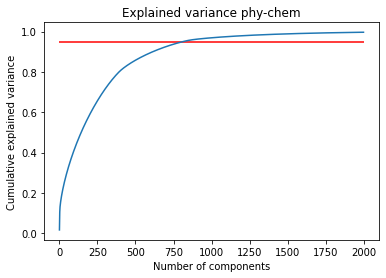

In [ ]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title(f'Explained variance {encoding}')
plt.hlines(y=0.95, xmin=-1, xmax=2000, colors='red')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig(path+f'images/explained_variance_{encoding}.png')

In [ ]:
# Store the fitted SVD so it can be applied to new data
pickle.dump(svd, open(path+f'svd/svd_{encoding}.pickle', 'wb'))

In [ ]:
# Load SVD object
svd = pickle.load(open(path+f'svd/svd_{encoding}.pickle', 'rb'))
X_train_svd, X_val_svd, X_test_svd, X_c_svd = svd.transform(X_train), svd.transform(X_val), svd.transform(X_test), svd.transform(X_c)
sum(svd.explained_variance_ratio_)

0.9582916160987319

# Step 5: Hyperparameters tuning and model training

In [ ]:
# Metrics to be used for training
METRICS = [BinaryAccuracy(name='accuracy'), AUC(name='auc'), Precision(name='precision'), f1(num_classes=1, name='f1'), Recall(name='recall')]

def build_model(hp):
  """
  Keras model is returned from keras tuner
  """
  model = Sequential()
  model.add(Dense(units = hp.Choice('units', [30,50,100,150,200,250,300]),
                  activation = 'sigmoid',
                  kernel_initializer = 'he_uniform'))
  model.add(Dropout(hp.Choice('rate', [0.2,0.3,0.4,0.5])))
  model.add(Dense(units = 2,
                  activation = hp.Choice('activation', ['relu', 'sigmoid','tanh']),
                  kernel_initializer = 'he_uniform'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'he_uniform'))
  model.compile(loss = 'binary_crossentropy', optimizer = hp.Choice('optimizer', ['SGD', 'adam']), metrics=METRICS)
  return model

# Stopping condition
stop_early = EarlyStopping(monitor="auc", patience=3, min_delta=0.01)

# Search of hyperparameters
tuner = kt.BayesianOptimization(build_model, objective = kt.Objective("val_auc", direction="max"), max_trials=10, overwrite=True)
tuner.search(X_train_svd, y_train, epochs=40, validation_data=(X_val_svd, y_val), callbacks=[stop_early], batch_size=32, shuffle=True, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Retrain the model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_svd, y_train, validation_data=(X_val_svd, y_val), epochs=40, shuffle = True, verbose=1, batch_size=32, callbacks=[stop_early])

Trial 5 Complete [00h 00m 11s]
val_auc: 0.9021775126457214

Best val_auc So Far: 0.9363276362419128
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/40
284/284 [==============================] - 3s 7ms/step - loss: 0.5875 - accuracy: 0.7421 - auc: 0.7137 - precision: 0.7411 - f1: 0.8289 - recall: 0.9771 - val_loss: 0.4882 - val_accuracy: 0.7070 - val_auc: 0.8253 - val_precision: 0.7070 - val_f1: 0.8284 - val_recall: 1.0000
Epoch 2/40
284/284 [==============================] - 1s 4ms/step - loss: 0.4494 - accuracy: 0.7080 - auc: 0.8335 - precision: 0.7080 - f1: 0.8290 - recall: 1.0000 - val_loss: 0.4130 - val_accuracy: 0.7070 - val_auc: 0.8806 - val_precision: 0.7070 - val_f1: 0.8284 - val_recall: 1.0000
Epoch 3/40
284/284 [==============================] - 1s 4ms/step - loss: 0.3884 - accuracy: 0.7832 - auc: 0.8797 - precision: 0.8202 - f1: 0.8290 - recall: 0.8885 - val_loss: 0.3767 - val_accuracy: 0.8330 - val_auc: 0.8988 - val_precision: 0.8723 - val_f1: 

In [ ]:
best_hps.values

{'activation': 'sigmoid', 'optimizer': 'adam', 'rate': 0.2, 'units': 30}

# Step 6: Model evaluation

In [ ]:
def model_evaluation(path, encoding, history, model, X_train, X_val, X_test, X_c, y_train, y_val, y_test, y_c):
  # Obtain all metrics
  train_metrics = model.evaluate(X_train, y_train, verbose=0)
  val_metrics = model.evaluate(X_val, y_val, verbose=0)
  test_metrics = model.evaluate(X_test, y_test, verbose=0)
  curated_metrics = model.evaluate(X_c, y_c, verbose=0)
  df_metrics = pd.DataFrame(data=[train_metrics[1:],val_metrics[1:],test_metrics[1:],curated_metrics[1:]],
                            columns=['Accuracy','AUC','Precision', 'F1', 'Recall'],index=['Train','Validation','Test','Curated'])
  df_metrics.to_csv(path+f'metrics/{encoding}.csv')
  print(df_metrics)

  # Plot loss during training
  plt.subplot(211)
  plt.title('Loss')
  plt.plot(history['loss'], label='train')
  plt.plot(history['val_loss'], label='validation')
  plt.legend()

  # Plot accuracy during training
  plt.subplot(212)
  plt.title('Accuracy')
  plt.plot(history['accuracy'], label='train')
  plt.plot(history['val_accuracy'], label='validation')
  plt.legend()
  plt.tight_layout()
  plt.savefig(path+f'images/train_validation_curves_{encoding}.png')
  plt.show()

  # Plot CM
  yhat = model.predict(X_test)>0.5
  yhat.astype('int32')
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat), display_labels=["GR","OR"])
  disp = disp.plot(cmap="Blues", values_format='')
  plt.savefig(path+f'images/confusion_matrix_{encoding}.png')
  plt.show()

  # ROC curve
  y_score = model.predict(X_test_svd)
  fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=encoding).plot()
  plt.savefig(path+f'images/roc_curve_{encoding}.png')

  # Model architecture
  plot_model(model, to_file=path+f'images/model_plot_{encoding}.png', show_shapes=True, show_layer_names=True)
  
  # Save our model
  model.save(path+f'models/{encoding}.h5')

            Accuracy       AUC  Precision            F1    Recall
Train       0.990631  0.999499   0.989951  [0.82904166]  0.996886
Validation  0.903439  0.957308   0.918404   [0.8283611]  0.947615
Test        0.907769  0.964159   0.920378   [0.8304659]  0.952514
Curated     0.970297  1.000000   0.945455   [0.6797386]  1.000000


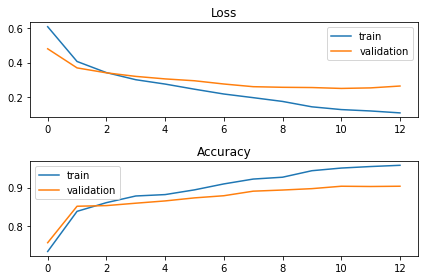

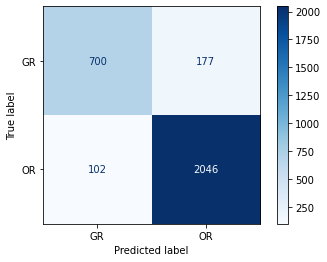

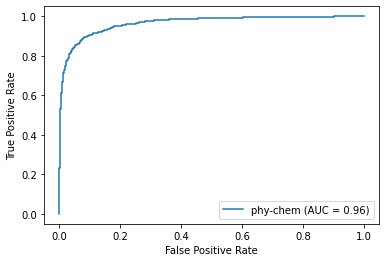

In [ ]:
model_evaluation(path, encoding, history.history, model, X_train_svd, X_val_svd, X_test_svd, X_c_svd, y_train, y_val, y_test, y_c)

 ## Embedded sequences

In [ ]:
def get_2D(encoding, model, svd, X, y, save):
  # Reuse layers from model
  encoder = Sequential()
  encoder.add(model.layers[0])
  encoder.add(model.layers[1])
  encoder.add(model.layers[2])
  encoder.compile(loss='binary_crossentropy', optimizer='adam')

  # Encoded version of sequences
  X_svd = svd.transform(X)
  X_embedded = encoder.predict(X_svd)

  # Two dimensional representation of sequences
  colors = y.copy().astype('object')
  colors[colors==0] = 'red'
  colors[colors==1] = 'blue'
  scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors)
  plt.title(f'Scatter plot of sequences for {encoding}')
  pop_a = mpatches.Patch(color='red', label='GR seqs')
  pop_b = mpatches.Patch(color='blue', label='OR seqs')
  plt.legend(handles=[pop_a,pop_b])
  if save==True:
    plt.savefig(path+f'images/2D_{encoding}.png')
  plt.show()

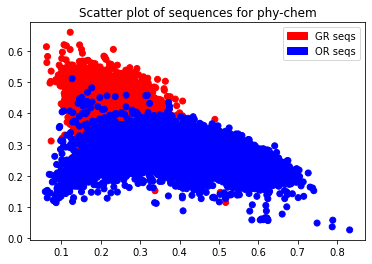

In [ ]:
get_2D(encoding, model, svd, X, y, True)

## Bootstrap Confidence intervals

In [ ]:
#https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
def bootstrap_samples(model, X, y):
  res = []
  # Seed the random number generator
  seed(123)
  # Bootstrap
  scores = {k:[] for k in ['Accuracy','Precision','Recall','AUC','F1']}
  for _ in tqdm(range(1000)):
    # Bootstrap sample
    indices = randint(0, len(X_test_svd)-1, len(y))
    X_sample, y_sample = X_test_svd[indices], y_test[indices]
    # Predict test values
    yhat = model.predict(X_sample)>0.5
    scores['Accuracy'].append(accuracy_score(y_sample,yhat))
    scores['Precision'].append(precision_score(y_sample,yhat))
    scores['Recall'].append(recall_score(y_sample,yhat))
    scores['AUC'].append(roc_auc_score(y_sample,yhat))
    scores['F1'].append(f1_score(y_sample,yhat))
  # Calculate 95% confidence intervals (100 - alpha)
  alpha = 5.0
  # Calculate lower percentile (e.g. 2.5)
  lower_p = alpha / 2.0
  # Calculate upper percentile (e.g. 97.5)
  upper_p = (100 - alpha) + (alpha / 2.0)
  # For each metric
  for k,v in scores.items():
    # Retrieve observation at lower percentile
    lower = max(0.0, percentile(v, lower_p))
    # Retrieve observation at upper percentile
    upper = min(1.0, percentile(v, upper_p))
    res.append([upper,median(v),lower])
  res = np.array(res)
  res = np.rot90(res)
  df_metrics = pd.DataFrame(data=res, columns=scores.keys(), index=['2.5th percentile', '50th percentile', '97.5th percentile'])
  df_metrics.to_csv(path+f'metrics/bootstrap_{encoding}.csv')
  print(df_metrics)
  return scores

In [ ]:
model = keras.models.load_model(path+f'models/{encoding}.h5')
metrics = bootstrap_samples(model, X_test_svd, y_test)

100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]

                   Accuracy  Precision    Recall       AUC        F1
2.5th percentile   0.902479   0.906177  0.957334  0.860920  0.932899
50th percentile    0.912727   0.916960  0.964736  0.875247  0.940088
97.5th percentile  0.921983   0.927390  0.972196  0.888806  0.946816


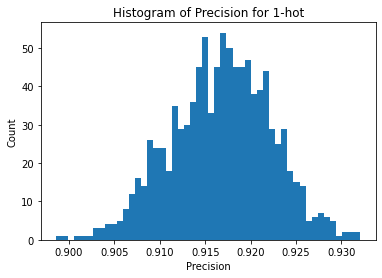

In [ ]:
plt.hist(metrics['Precision'], 50)
plt.xlabel('Precision')
plt.ylabel('Count')
plt.title(f'Histogram of Precision for {encoding}')
plt.savefig(path+f'images/bootstrap_{encoding}.png')
plt.show()

# Step 7: Final model evaluation

In [ ]:
# Load dictionaries of encondings
with open(path+'encodings.json') as json_file:
  d_codes = json.load(json_file)

In [ ]:
def get_yhats_final(d_codes):
  ls_encodings = ['1-hot','phy-chem','10-factor']
  aux = list()
  for encoding in tqdm(ls_encodings):
    _,_,_,_,X_test,_,_,_,y_test,_ = get_datasets(path+f'df_encoded_{encoding}.csv')
    # Apply SVD
    svd = pickle.load(open(path+f'svd/svd_{encoding}.pickle', 'rb'))
    X_svd = svd.transform(X_test)
    # Load model
    model = keras.models.load_model(path+f'models/{encoding}.h5')
    # Make predictions
    yhat = model.predict(X_svd)
    aux.append(yhat)
  return aux, y_test

def get_scores(y_test, yhats):
  aux, ts = list(), list()
  for threshold in range(50,100,5):
    t = threshold/100
    res = np.column_stack(yhats)
    res = res >= t
    res = res.sum(1)
    yhat = np.where(res==3,1,0)
    ts.append(t)
    aux.append([accuracy_score(y_test,yhat),precision_score(y_test,yhat),recall_score(y_test,yhat),roc_auc_score(y_test,yhat),f1_score(y_test,yhat)])
  res = pd.DataFrame(aux, columns = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1'])
  res['Threshold'] = ts
  return res

In [ ]:
yhats, y_test= get_yhats_final(d_codes)

100%|██████████| 3/3 [02:25<00:00, 48.63s/it]


In [ ]:
df_scores = get_scores(y_test, yhats)

In [ ]:
df_scores

,Accuracy,Precision,Recall,AUC,F1,Threshold
0,0.900496,0.971414,0.885940,0.911043,0.926710,0.50
1,0.893884,0.974545,0.873371,0.908749,0.921188,0.55
2,0.887273,0.975777,0.862663,0.905106,0.915740,0.60
3,0.880000,0.980097,0.848231,0.903021,0.909409,0.65
4,0.873388,0.984624,0.834730,0.901401,0.903502,0.70
5,0.866116,0.989332,0.820298,0.899317,0.896920,0.75
6,0.853884,0.993064,0.799814,0.893065,0.886024,0.80
7,0.834050,0.993405,0.771415,0.879436,0.868449,0.85
8,0.803306,0.996166,0.725791,0.859475,0.839752,0.90
9,0.731240,0.998506,0.622439,0.810079,0.766848,0.95


In [ ]:
df_scores.to_csv(path+'metrics/metrics_final_threshold.csv')

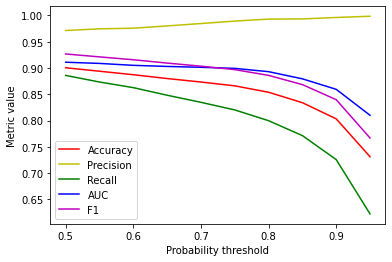

In [ ]:
# Plot a simple line chart
plt.plot(df_scores['Threshold'], df_scores['Accuracy'], color='r', label='Accuracy')
plt.plot(df_scores['Threshold'], df_scores['Precision'], color='y', label='Precision')
plt.plot(df_scores['Threshold'], df_scores['Recall'], color='g', label='Recall')
plt.plot(df_scores['Threshold'], df_scores['AUC'], color='b', label='AUC')
plt.plot(df_scores['Threshold'], df_scores['F1'], color='m', label='F1')
#plt.title('Metrics values for different thresholds')
plt.xlabel('Probability threshold')
plt.ylabel('Metric value')
plt.legend()
plt.show()

# Step 8: Non-insect sequences

In [ ]:
def get_yhats(df_to_encode, d_codes):
  ls_encodings = ['1-hot','phy-chem','10-factor']
  aux = list()
  for encoding in ls_encodings:
    # Encode seqs
    df_enc = get_df_encoded(df_to_encode[df_to_encode.Length<=600], 600, d_codes[encoding])
    # Apply SVD
    svd = pickle.load(open(path+f'svd/svd_{encoding}.pickle', 'rb'))
    X = svd.transform(df_enc.loc[:,df_enc.columns!='Category'].values)
    # Load model
    model = keras.models.load_model(path+f'models/{encoding}.h5')
    # Make predictions
    yhat = model.predict(X)
    aux.append(yhat)
  df_res = pd.DataFrame(data = np.column_stack(aux), columns = ls_encodings)
  df_res['ID'] = df_enc.index
  df_res.set_index('ID', inplace=True)
  return df_res

In [ ]:
# Load dictionaries of encondings
with open(path+'encodings.json') as json_file:
  d_codes = json.load(json_file)

# Load sequeces to predict
df = pd.read_csv(path+'CR_noninsect.csv',index_col=0)

# Make predictions
df_yhat = get_yhats(df[['ID','Seq','Category','Length']], d_codes)

3964it [00:07, 529.76it/s]
3964it [00:02, 1481.07it/s]
3964it [00:03, 1114.18it/s]


In [ ]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
n = []
for threshold in thresholds:
  df_aux = df_yhat[(df_yhat['1-hot']>threshold)&(df_yhat['phy-chem']>threshold)&(df_yhat['10-factor']>threshold)]
  n.append(len(df_aux))

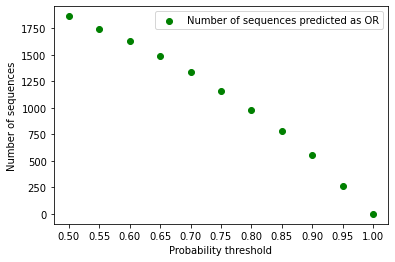

In [ ]:
plt.scatter(thresholds, n, color='g', label='Number of sequences predicted as OR')
plt.xticks(thresholds)
#plt.title('Number of predicted OR sequences for different thresholds')
plt.xlabel('Probability threshold')
plt.ylabel('Number of sequences')
plt.legend()
plt.show()

In [ ]:
df_yhat = pd.read_csv(path+'yhat_seqs_noinsect.csv')

In [ ]:
df_yhat

,ID,1-hot,phy-chem,10-factor
0,AgenCR1,0.991435,0.221487,0.966328
1,AgenCR2,0.015419,0.645862,0.655607
2,AgenCR3,0.007090,0.444076,0.111274
3,AgenCR4,0.074436,0.881370,0.404372
4,AgenCR5,0.004131,0.860673,0.080759
...,...,...,...,...
3951,TurtCR261p,0.663449,0.611346,0.390335
3952,TurtCR262p,0.976281,0.999953,0.960403
3953,TurtCR263p,0.551649,0.019098,0.775349
3954,TurtCR264p,0.919085,0.940356,0.336348


Text(0, 0.5, 'Number of sequences')

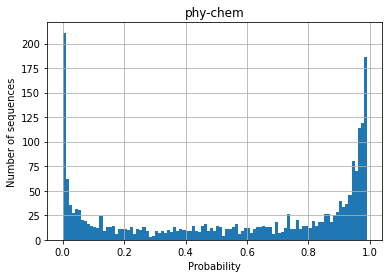

In [ ]:
enc = 'phy-chem'
my_bins = [i/100 for i in range(0,100,1)]
df_yhat.hist(enc,bins=my_bins)
#plt.title(f'Prediction probabilities for {enc}')
plt.xlabel('Probability')
plt.ylabel('Number of sequences')

In [ ]:
df_yhat.to_csv(path+'yhat_seqs_noinsect.csv')

In [ ]:
pip install -U notebook-as-pdf

In [ ]:
pip install pyppeteer